# **Exclusion Criterion**
<br>
### Contents:
> 1. [Introduction](#1)
> 2. [Getting the data](#2)
> 3. [Exploring the data](#3)
> 4. [Transforming the data](#4)
> 5. [Determing exclusions](#5)

<a id='1'></a> 
## *Introduction*
 The aim of this notebook is to explore the exclusions data in order to develop a exclusion criterion that is more statistically sound. 
 
Previously our exclusion criterion was as follows: 
We calculated the SD of participants' estimates for each subcondition for the bisection task. A subcondition for a participant was excluded if the SD  of their estimates was greater than 0.2 for a subcondition. If a participant had five or more excluded subconditions, they were replaced. 

Following diussions with Ron and Maddison we have decided to develop a new exclusion criterion. 

Goals:
1. Find what other studies have been using for exclusions. 
2. Look at the distribution of variance
3. Look at how variances change through trials/subconditions. Generally, they should converge to a stable value.
<br>

<br> 
**NOTE: **
If you plan on running the code in this notebook it is easiest to do so through the __[Anaconda](https://conda.io/docs/user-guide/install/download.html)__ package, as it comes with all the relevant libraries saving you headahce of dowloanding them individually. (Its also opensource ... unlike Excel LOL)

<a id='2'></a>
## *Getting the data* 

The Gamma 4 condition data is going to be explored to determine the exclusion criteron. The data was downloaded from google-drive. In the future we will be grabbing the data from the remote server that we recently just got acesss to. 

Note, if you are running the notebook  make sure to change the ```path``` variable to correpsond to the correct file-path (i.e. the file-path of where the excel sheet is). <br> 
<br> __[How to get a file-path on a mac](https://apple.stackexchange.com/questions/252171/mac-finder-getting-the-path-of-a-directory-or-file-as-as-string)__
<br> __[How to get a file-path on windows](https://stackoverflow.com/questions/32573080/how-can-i-get-the-path-to-a-file-in-windows-10)__

In [6]:
#Import statements
import numpy as np
import pandas as pd 


import matplotlib.pyplot as plt 
import matplotlib.backends.backend_pdf 
import seaborn as sns

import math 
import pylab 
from scipy import stats

from statsmodels import robust

import colorama
from colorama import Fore

In [11]:
#Read the data *** Make sure path is set to the correct file-path *** 
path = '/Users/Akshi/Desktop/Correlation/Correlation_Analysis/Data/Gamma_4.xlsm' 
Gamma4_sheet = pd.ExcelFile(path)

In [12]:
#Parse the Exclusions sheet to create a Pandas DataFrame
G4_exlcusions = Gamma4_sheet.parse('1. Exclusions')
#Select the columns that are needed and create a new DataFrame with them
G4 = G4_exlcusions.loc[22:,["ID","subCondition","highRef","estimatedMid","lowRef","roundType", "AnchorValues"]]
G4[:5]

,ID,subCondition,highRef,estimatedMid,lowRef,roundType,AnchorValues
22,1.0,1.0,1.0,0.000000,0.000000,test,0.250000
23,NaN,1.0,1.0,0.895304,0.000000,test,0.156265
24,NaN,1.0,1.0,0.891094,0.000000,test,0.152954
25,NaN,1.0,1.0,0.935698,0.000000,test,0.189833
26,NaN,2.0,1.0,0.944162,0.680524,test,0.010795


So far a dataframe object from the exlcusions sheet has been made. <br>
__[Information on DataFrames](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python)__

<a id='3'></a>
## *Exploring the data*
Now that a DataFrame object containg the relevant columns has been created, its time to explore the data. 

For the given Gamma condition, histograms of the mid-point estimates for each of subconditions were plotted. This exercise in visualzation aimed to show that most Gamma conditons follow a bi-modal distribution for the first few subcondtions, but towards the later subconditions the participant estimates appear to converge towards a uni-modal distribution.

The Seaborn library was used for plotting. 
__[Information on Seaborn](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial)__

In [13]:
#Group the DataFrame by sub-condition
G4_byCond = G4.groupby("subCondition")
#Each participant completed four trials for a given-subcondition. 
#Note the change in ID number every four trials for sub-condition
G4_byCond.get_group(1)[:8]

,ID,subCondition,highRef,estimatedMid,lowRef,roundType,AnchorValues
22,1.0,1.0,1.0,0.000000,0.0,test,0.250000
23,NaN,1.0,1.0,0.895304,0.0,test,0.156265
24,NaN,1.0,1.0,0.891094,0.0,test,0.152954
25,NaN,1.0,1.0,0.935698,0.0,test,0.189833
82,2.0,1.0,1.0,0.949902,0.0,test,0.202412
83,NaN,1.0,1.0,0.931889,0.0,test,0.186528
84,NaN,1.0,1.0,0.888663,0.0,test,0.151059
85,NaN,1.0,1.0,0.871137,0.0,test,0.137743


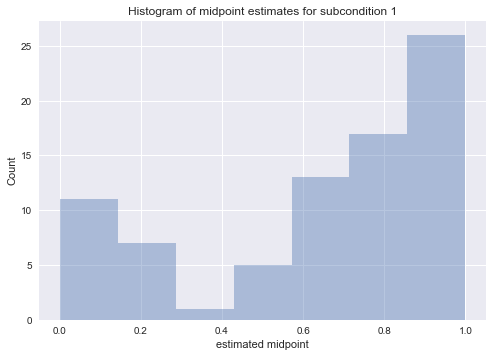

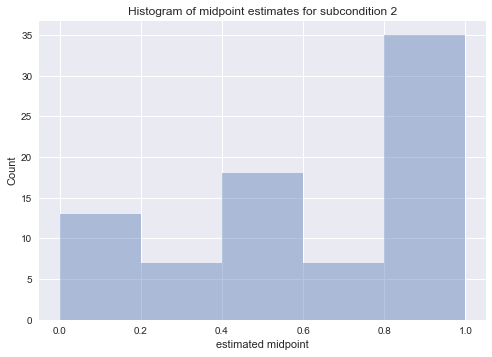

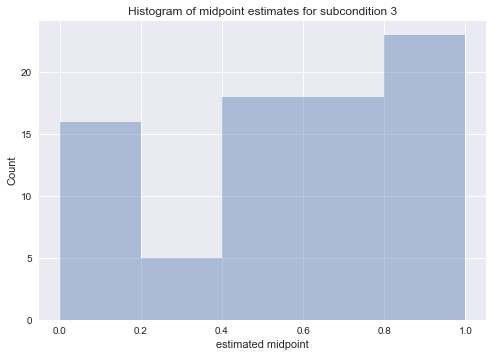

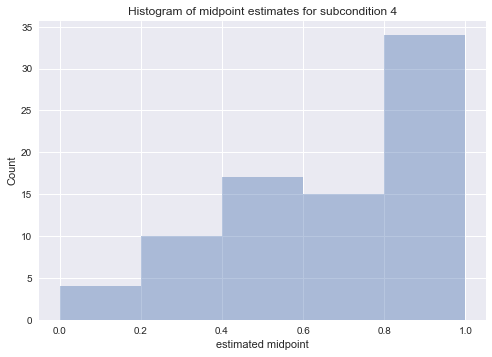

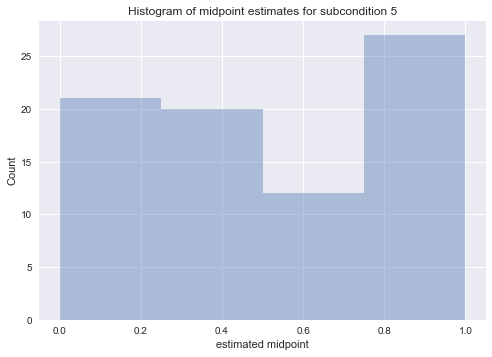

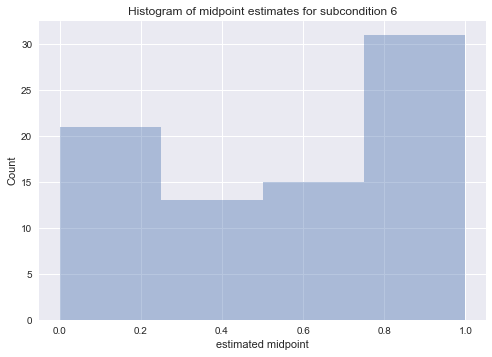

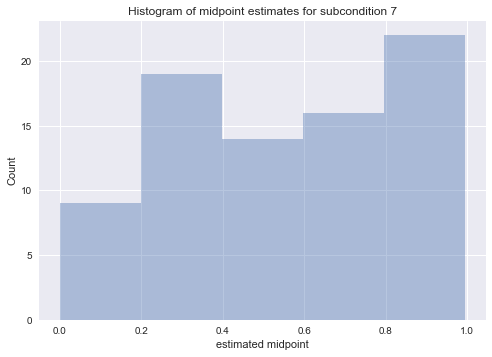

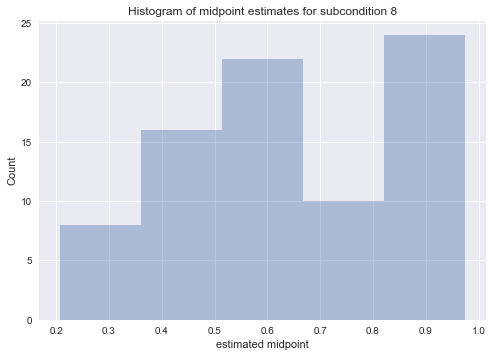

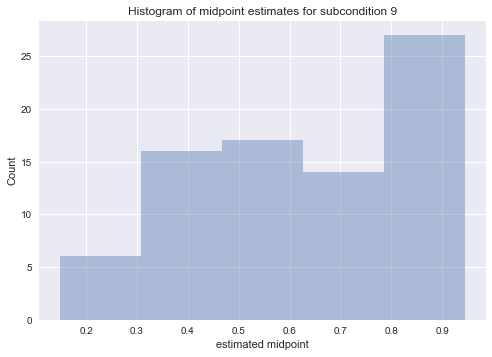

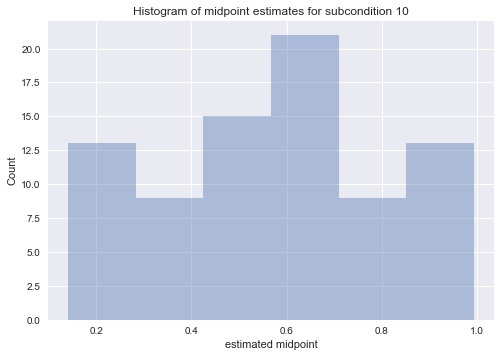

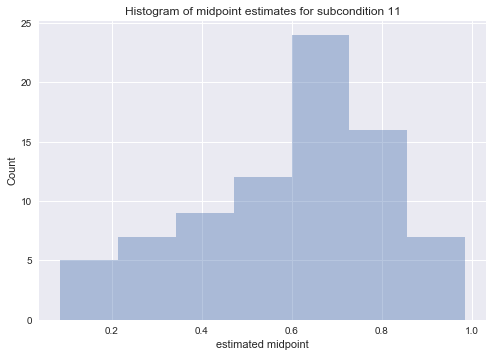

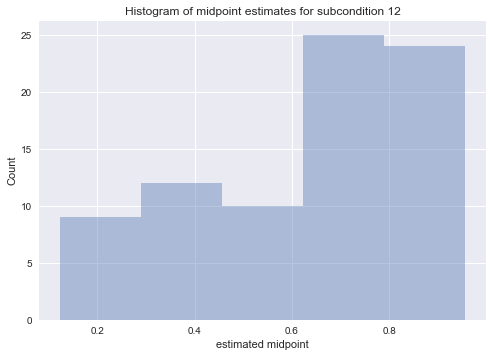

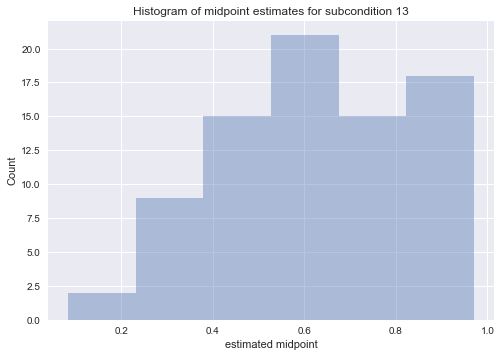

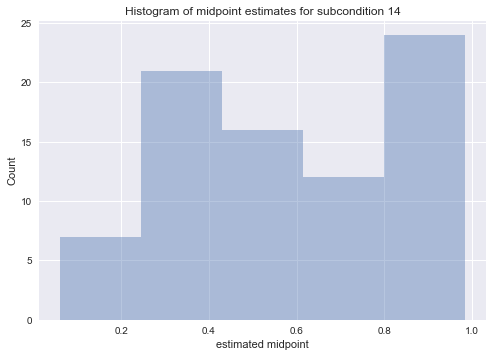

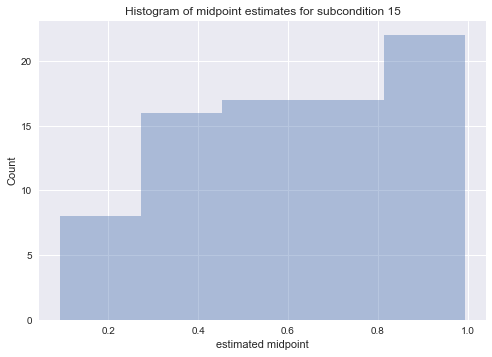

In [30]:
#Plot the distribution of mid-point estimates for each subcondition
for i in range(1,16):
    cond = G4_byCond.get_group(i)
    estimates =cond["estimatedMid"]
    cond_plt = sns.distplot(estimates, kde=False)
    plt.ylabel('Count')
    plt.xlabel('estimated midpoint')
    plt.title("Histogram of midpoint estimates for subcondition " + str(i))
    plt.show()


The histograms above clearly show a bi-modal distrubtion for the initial subconditons.<font color='red'> (Talk a bit more about why? Mostly due to anchoring, anchor towards what they are shown --> Ask Jessica)</font>. Towards the later subconditions the participants guess seem to converge to a fairly negatively skewed uni-modal distribution. This seems to be consistent with what we expect, with participants overestimating. <font color='red'> (Confirm this is correct and link some sources)</font>

<a id='4'></a>
## Transforming the data
Since the distributions are clearly not normal we need to transform the data so that we can conduct standard statistical test to determine exclusions. This further highlights the need to develop a more rigours exlcusion criterion. 

The next section will transform the data to produce a uni-modal distribution. The transformation that was disscused is as follows: 

\begin{align*} 
Let \; T_i \; be \; the \; i\operatorname{-}th \; trial \;  for  \; a \;  given \; subcondition: \newline 
Transform \; = \; |(T_1 + T_3) - (T_2 + T_4)|
\end{align*}

In [33]:
#Distribution is very bi-modal due to anchoring, lets try to make it uni-modal 
#Spencer suggested we could do the following: abs((first attempt - third attempt) + (second attempt - foruth attempt))
def transform(sub_cond):
    '''A function that combines attempts for a subcondition, in order to account for anchoring.
        The resulting distribution should be fairly normal
        @param sub_cond: subconditon that will be transformed'''
    
    #0 corresponds to first attempt 
    first_idx = 0 
    second_idx = 1
    third_idx = 2
    fourth_idx = 3 
    
    #Get estimatedMid column from DataFrame
    estimates = sub_cond['estimatedMid']
    
    #Create a np-array for transformed data
    uni_modal= np.empty(int(len(sub_cond)/4))
    
    for i in range(int(len(sub_cond)/4)):
        #Get attempts for a participant
        first_atmpt = estimates.iloc[first_idx]
        second_atmpt = estimates.iloc[second_idx]
        third_atmpt = estimates.iloc[third_idx]
        fourth_atmpt = estimates.iloc[fourth_idx]
        #Calculate new estimate via Spencers suggested formula
        estimate = abs(((first_atmpt+third_atmpt) - (second_atmpt+fourth_atmpt)))
        #Add to np-array
        uni_modal[i] = estimate
        #Increase index to next participant
        first_idx+=4
        second_idx+=4
        third_idx+=4
        fourth_idx+=4
    
        
    #return transformed data 
    return uni_modal

def plotter(measurements):
    '''Fucntion to plot distribution and Normal QQ
        @param measurements: np array of vlaues that will be plotted'''
    
    #plot histogram
    plt.subplot(1,2,1)
    sns.distplot(measurements, kde=False)
    plt.ylabel('Count')
    plt.xlabel('estimated midpoint')
    plt.title("Histogram of midpoint estimates for subcondition " + str(i))
    #Normal QQ plot
    plt.subplot(1,2,2)
    stats.probplot(measurements, dist="norm", plot=plt)
    plt.title("Subcondition " + str(i) + " QQ plot")
    plt.show()
    

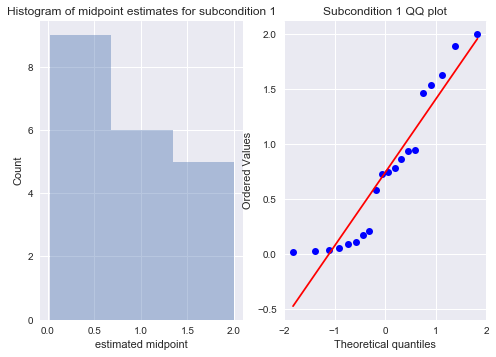

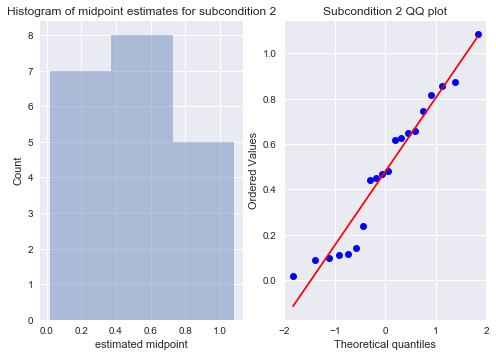

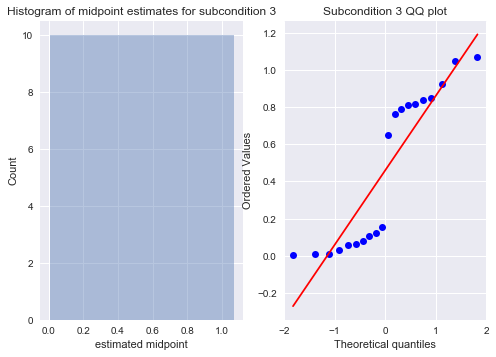

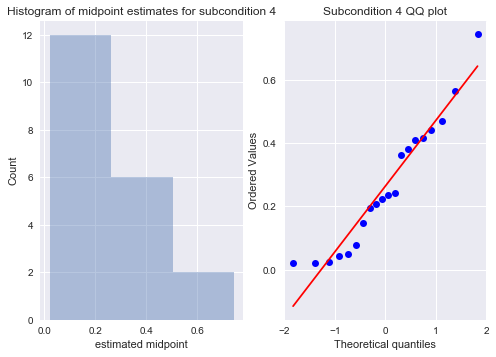

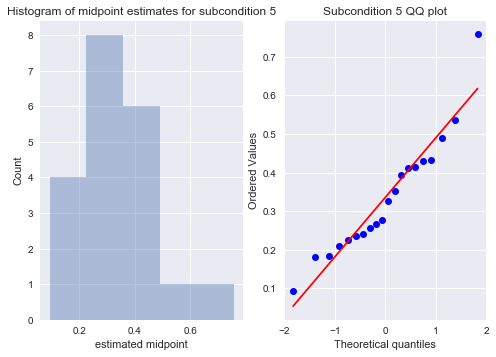

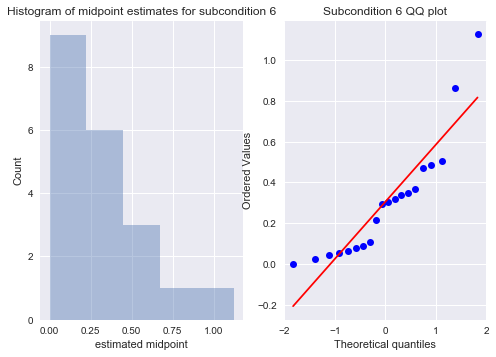

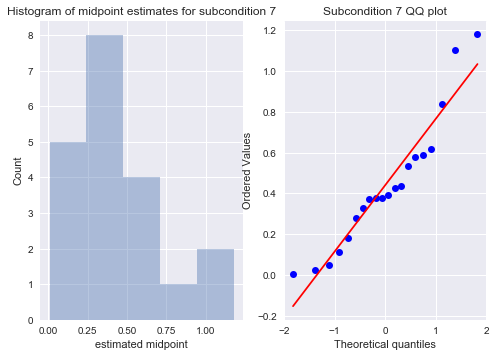

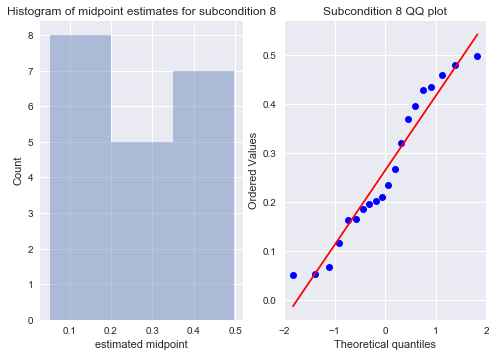

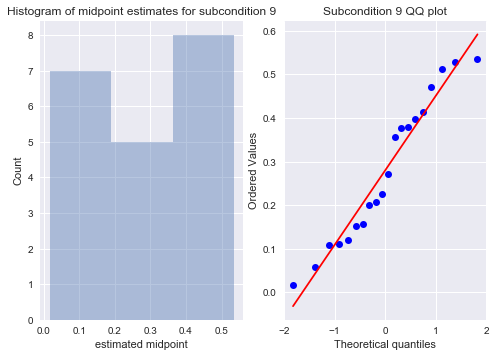

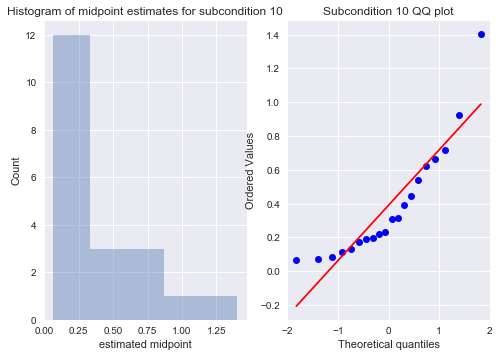

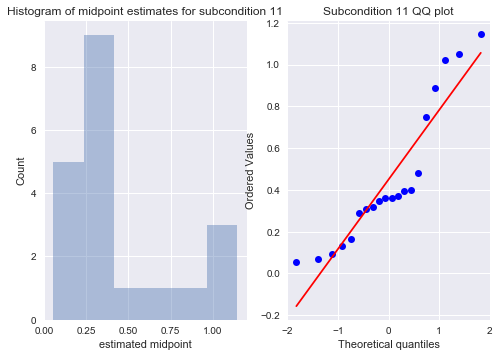

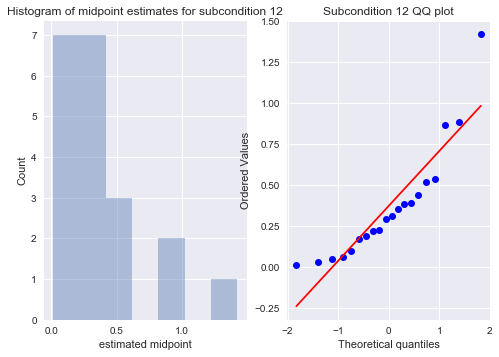

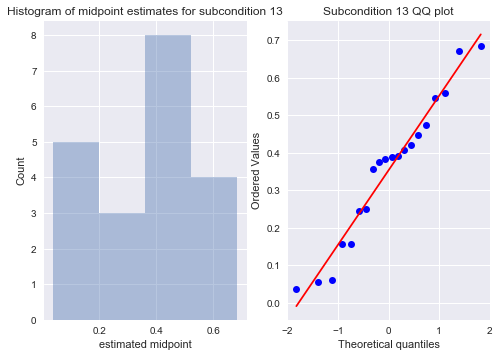

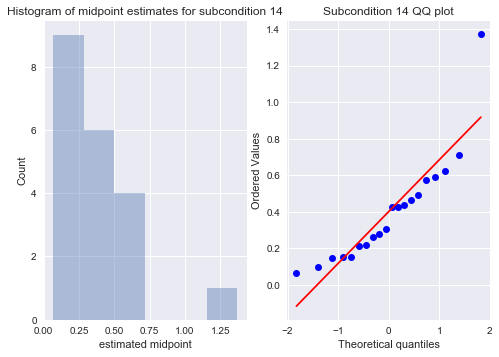

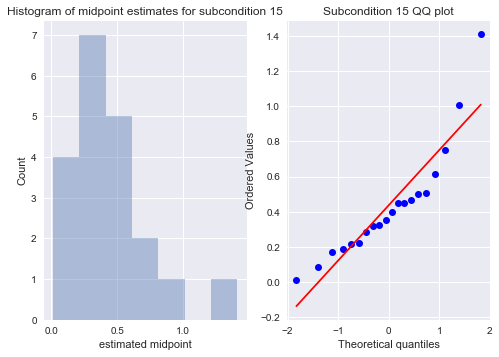

In [34]:
#Apply transform function to every subcondition
for i in range(1,16):
    #Get subcondition from DataFrame
    sub_cond= G4_byCond.get_group(i)
    #Apply transform function
    measurements = transform(sub_cond)
    plotter(measurements)

The distrubtion of the estimatd midpoints were transformed using Spencers suggested formula. A [QQ plot](http://seankross.com/2016/02/29/A-Q-Q-Plot-Dissection-Kit.html) for each subcondition was then constructed. Many of the QQ plots are charecteristic of being multi-modal. This would suggest that it might be incorrect to assume normality for most of the subconditions. (The sample size was quite small however, so we [cannot completely reject](https://stats.stackexchange.com/questions/133065/q-q-plot-and-sample-size) the assumptions of normality. 

Assuming that the distributions are normal but heavily tailed, we could try [transforming](https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55) them.

In [ ]:
#Apply transform distribution assuming they are heavily tailed
for i in range(1,16):
    #Get subcondition from DataFrame
    sub_cond= G4_byCond.get_group(i)
    #Apply transform function
    measurements = transform(sub_cond)
    measurements = measurements**(1/3)
    plotter(measurements)

The QQ plots after the [cube-root transform](http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_03.pdf) dont look that bad. Just to be sure, we could conduct a [normality test](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/) with some built in python functions.

In [15]:
def cbrt(sub_cond):
    '''function that preforms cubroot transform
        @param sub_cond :subcond that is going to be transformed '''
    #Get subcondition from DataFrame
    #Apply transform function
    measurements = transform(sub_cond)
    measurements = (measurements**(1/3))
    return measurements

for i in range(1,16):
    #Get subcondition from DataFrame
    sub_cond= G4_byCond.get_group(i)
    measurements = cbrt(sub_cond)
    #K^2 test
    stat, p = stats.normaltest(measurements)
    print(Fore.BLUE+"Subcondition " + str(i) +  " normaility test: ")
    print(Fore.BLUE+'Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(Fore.GREEN+ 'Sample looks Gaussian (fail to reject H0)')
    else:
        print(Fore.RED + 'SAMPLE NOT GAUSSIAN!!!!'  + '(reject H0)')
    print(Fore.BLUE + "---------------------------------")

Subcondition 1 normaility test: 
Statistics=5.623, p=0.060
Sample looks Gaussian (fail to reject H0)
---------------------------------
Subcondition 2 normaility test: 
Statistics=2.145, p=0.342
Sample looks Gaussian (fail to reject H0)
---------------------------------
Subcondition 3 normaility test: 
Statistics=12.695, p=0.002
SAMPLE NOT GAUSSIAN!!!!(reject H0)
---------------------------------
Subcondition 4 normaility test: 
Statistics=2.487, p=0.288
Sample looks Gaussian (fail to reject H0)
---------------------------------
Subcondition 5 normaility test: 
Statistics=0.467, p=0.792
Sample looks Gaussian (fail to reject H0)
---------------------------------
Subcondition 6 normaility test: 
Statistics=1.396, p=0.498
Sample looks Gaussian (fail to reject H0)
---------------------------------
Subcondition 7 normaility test: 
Statistics=2.454, p=0.293
Sample looks Gaussian (fail to reject H0)
---------------------------------
Subcondition 8 normaility test: 
Statistics=1.472, p=0.479
Sa

After preforming the cuberoot transform a test of normality was conducted that failed to reject our normaility assumption. *(Note: If the ```cbrt(sub_cond)``` is not called on the data, then the assumptions of normality fails.)* Therefore its necessary to transform the data before continuing. 

<a id='5'></a>
## *Determining exclusions*

Since our normality assumptions hold for all but one subcondition at $\alpha = 0.05$ we can now determine exclsuions. 

<br>
Creating an exclusion criterion is essentially the same as determing and removing any outliers from our data. Previously we used SD or something similar to a Z-scores to determine exclusion, however after preforming Spencers suggested transformation we reduced the number of data points down to $n =20$ (essentially the number of participants). Therefore using a z-score to determine outliers here would not be a very robust method, since it requires using the mean and SD, both are heavily influenced by outliers. Therefore we have chosen to use  the [median of all absolute deviations (MAD) and the median to preform a z-score like test to determine outliers.](https://wis.kuleuven.be/stat/robust/papers/2011/rousseeuwhubert-robuststatisticsforoutlierdetectio.pdf)

$$Robust-Score = ( x_i - \underset{\rm j=1,..,n}{\rm median(x_j))} \; /\; MAD $$

Excluded a participant if their Robust-Score was greater than 2.5 for the subdcondintion and if they had more than 5 exclusions re-run them.  <font color ='red'>(We can play around with this. Speak with Ron about it)</font>


In [35]:
def get_score(data):
    '''Function to calculate RobustScore as defined above
        @param data: array '''
    
    score_list = []
    for i in range(len(data)):
        #calculate MAD and median
        mad = robust.scale.mad(data)
        median = np.median(data)
        #Calculate score
        num = (data[i]-median)
        denom = mad
        score = num/denom
        #add to list
        score_list.append(score)
        
    return score_list

In [36]:
#list_score[i] contains RobustScores for subconditon i+1 (i.e. list_score[0] is RobustScores for subconditon 1)
list_scores = []
#exclusions_idx contains the indicies of any values for a subconditon that should be excluded
exclusions_idx = []

for i in range(1,16):
    #Get subcondition from DataFrame
    sub_cond= G4_byCond.get_group(i)
    #Transform and normalise data
    norm_data = cbrt(sub_cond)
    #get robust score and take their absolute value 
    sub_cond_score = np.abs(np.array(get_score(norm_data)))
    #add sub_conds scores to a list
    list_scores.append(np.abs(sub_cond_score))
    #get indicies of exclusions
    exclusions_idx.append(np.where(sub_cond_score > 2.5)[0].tolist())
    #increment index to match participant IDs
    IDs =  exclusions_idx[i-1]
    if(IDs):
        ID = [x+1 for x in IDs]
        IDs = ID
    exclusions_idx[i-1] = IDs
    
    


In [37]:
#Print exclusions
for i in range(len(list_scores)):
    sub_cond = exclusions_idx[i]
     
    #See if list isnt empty
    if sub_cond:
        print('\033[1m' + '\033[4m' + Fore.BLUE + "Subconditon " + str(i+1)) 
        print('\033[0m' +  Fore.RED + "Exclude participant(s): "  , end='' )
        print(*sub_cond, sep=',')
        print('\n')
    else: 
        print('\033[1m'+ '\033[4m'+ Fore.BLUE + "Subconditon " + str(i+1))
        print('\033[0m' + Fore.GREEN+"No exclusions" )
        print('\n')

Subconditon 1
No exclusions


Subconditon 2
No exclusions


Subconditon 3
No exclusions


Subconditon 4
No exclusions


Subconditon 5
No exclusions


Subconditon 6
Exclude participant(s): 9


Subconditon 7
Exclude participant(s): 2,16


Subconditon 8
No exclusions


Subconditon 9
No exclusions


Subconditon 10
No exclusions


Subconditon 11
No exclusions


Subconditon 12
No exclusions


Subconditon 13
Exclude participant(s): 2,14


Subconditon 14
No exclusions


Subconditon 15
Exclude participant(s): 8,16




## **TODO**
* Add box-plots for each subcondition
* Print outputs to a nice PDF 
* Add some more explanations 

[Info about skewed outliers](https://stats.stackexchange.com/questions/129274/outlier-detection-on-skewed-distributions)